   In order to standardize the process of writing code to complete a task, we will proceed from five aspects: 
   - ① loading data and preprocessing, 
   - ② building a neural network framework, 
   - ③ defining training optimization functions, 
   - ④ setting optimization hyperparameters, 
   - ⑤ using model prediction.
    
   Here, a network structure based on residual connections is used (if you are interested, you can read the paper 《Deep Residual Learning for Image Recognition》). You can build other models yourself, and this sharing aims to demonstrate a standardized process for building models using Pytorch.

   In addition to building our own network, we also used a pre trained model. 
   These pre-trained models do not require us too much computational resources to use powerful models, only requiring minor modifications to the models. 
    The pre-trained model used here is the Resnet model, and more models can be found in the torchvision.models section on the Pytorch official website
    ([https://pytorch.org/vision/stable/models.html])

In [1]:
import os
print(os.getcwd()) #the path of the current direction
#the path of datasets: /kaggle/input/dogs-vs-cats

/kaggle/working


In [2]:
#import the packages we need
import torch 

In [3]:
##(设置数据转换器：图片大小不一、数据增强) 
from torchvision.transforms import v2 as T
def get_transform(train=True):
    transforms = []
    #Resize the size(调整大小)
    transforms.append(T.Resize((256,256))) 
    if train:
        #data augmentation(数据增强)
        transforms.append(T.RandomHorizontalFlip(p=0.6))
        transforms.append(T.RandomVerticalFlip(p=0.5))
    transforms.append(T.ToImage())
    transforms.append(T.ToDtype(torch.float32,scale = True ))
    return T.Compose(transforms)

##load data(加载数据)
from torchvision import datasets
train_data = datasets.ImageFolder(root = "../input/dogs-vs-cats/train" ,transform = get_transform(train = True))
valid_data = datasets.ImageFolder(root = "../input/dogs-vs-cats/test" ,transform = get_transform(train = False))
print(train_data)

classes = train_data.classes #Category of output data(输出数据的类别)
print(train_data.classes)
idx = train_data.class_to_idx
print(train_data.class_to_idx) #View the corresponding numbers for each category(查看各类对应的数字)

##put data in batchs(将数据分批)
from torch.utils import data
batch_sizes = 50
train_loader = data.DataLoader(dataset = train_data ,batch_size = batch_sizes , shuffle = True )
valid_loader = data.DataLoader(dataset = valid_data ,batch_size = batch_sizes , shuffle = True )
data_loader = {"train":train_loader,"valid":valid_loader}

Dataset ImageFolder
    Number of datapoints: 20000
    Root location: ../input/dogs-vs-cats/train
    StandardTransform
Transform: Compose(
                 Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.6)
                 RandomVerticalFlip(p=0.5)
                 ToImage()
                 ToDtype(scale=True)
           )
['cats', 'dogs']
{'cats': 0, 'dogs': 1}


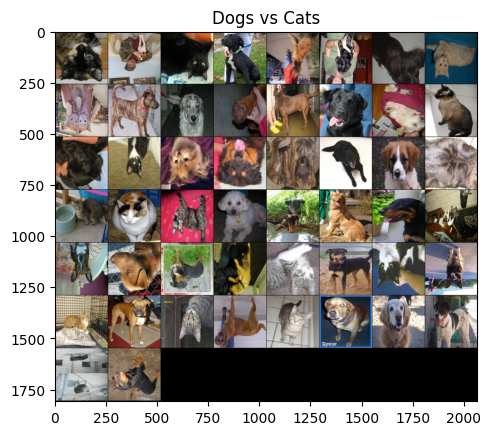

In [4]:
#show a batch of dataset(展示一批数据)
inputs,class_name = next(iter(train_loader))
from torchvision import utils
grid = utils.make_grid(inputs[0:56])#Display the first 56 images of a batch of 200 pictures（展示一批500张图片的前56张图）

from matplotlib import pyplot as plt
import numpy as np
#In order to display the images ,we need to convert the tensor to numpy（用pyplot展示图像数据要用numpy数据展示）
def imageshow(img,title=None):
    img = img.numpy().transpose((1,2,0)) #tensor(color,width,heigth) →numpy (width,heigth,color)
    plt.imshow(img)
    if title is not None:plt.title(title) 
    #Refresh the figure(刷新画面)
    plt.pause(1e-3) 

imageshow(grid,title = "Dogs vs Cats")

In [5]:
#Building a neural network framework(搭建神经网络框架)
from torch import nn
class Resnet(nn.Module):
    def ConvBlock(self,in_channels,out_channels,pool = False):
        layers = []
        layers.append(nn.Conv2d(in_channels,out_channels,stride = 1 , kernel_size = 3, padding = 1))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        if pool :
            layers.append(nn.MaxPool2d(kernel_size=2))
        return nn.Sequential(*layers) #The symbol * ndicates the use of variable quantity parameters(*标明使用可变数量参数)
        
    def __init__(self):
        super(Resnet,self).__init__()
        
        #Start building the framework(开始搭建框架)
        self.conv1 = nn.Conv2d(3,128,stride = 1 , kernel_size = 3, padding = 1)

        self.conv2 = nn.Conv2d(128,64,stride = 1, kernel_size = 1, padding = 0)

        self.conv3 = self.ConvBlock(64,32,pool = False)
        
        self.res1 = nn.Sequential(self.ConvBlock(32,32),self.ConvBlock(32,32))

        self.conv4 = self.ConvBlock(32,32,pool = True) 

        self.res2 = nn.Sequential(self.ConvBlock(32,32),self.ConvBlock(32,32))

        self.conv5 = self.ConvBlock(32,16,pool = True) 

        self.res3 = nn.Sequential(self.ConvBlock(16,16),self.ConvBlock(16,16))

        self.conv6 = self.ConvBlock(16,8,pool = True)

        self.res4 = nn.Sequential(self.ConvBlock(8,8),self.ConvBlock(8,8))

        self.conv7 = nn.Conv2d(8,4,stride = 1, kernel_size = 1, padding = 0)

        self.res5 = nn.Sequential(self.ConvBlock(4,4),self.ConvBlock(4,4))

        self.conv8 = nn.Conv2d(4,2,stride = 1, kernel_size = 1, padding = 0)
        
        self.fc = nn.Sequential(nn.Linear(in_features = 2048,out_features =32),
                                nn.Tanh(),
                                nn.Linear(32,16),
                                nn.ReLU(),
                                nn.Linear(16,2) #Binary classification（二分类)
                               )
    
    def forward(self,xb): #Rewrite the forward calculation method(重写前向计算方法)
        xb1 = self.conv1(xb)
        xb2 = self.conv2(xb1)
        xb3 = self.conv3(xb2)
        xb4 = self.res1(xb3)+xb3 #Add residual connection(添加残差连接)
        xb5 = self.conv4(xb4)
        xb6 = self.res2(xb5)+xb5
        xb7 = self.conv5(xb6)
        xb8 = self.res3(xb7)+xb7
        xb9 = self.conv6(xb8)
        xb10 = self.res4(xb9)+xb9
        xb11 = self.conv7(xb10)
        xb12 = self.res5(xb11)+xb11
        xb13 = self.conv8(xb12)
        xb14 = xb13.view(xb13.size(0),-1)#flatten (铺平)
        xb15 = self.fc(xb14)
        return xb15

##Model instantiation
model = Resnet()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") #use cuda or cpu
print(device)
model.to(device)    
print(model)


cpu
Resnet(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (conv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [6]:
#Design optimizer and loss function(设计优化器、损失函数)
from torch import optim
opt = optim.Adam(model.parameters(),lr = 1e-3) #optimizer(优化器)
lr_sch = optim.lr_scheduler.StepLR(opt , step_size = 10 , gamma = 0.1) #Learning rate adjuster(学习率调整器)

Loss_f = nn.CrossEntropyLoss() #loss function (损失函数)

In [7]:
#Set training function(设置训练函数)
#Conduct model training(进行模型训练)
##Define training function(定义训练函数) 

import time
from tempfile import TemporaryDirectory #Used for storing temporary information（用于储存临时信息）
from pathlib import *

from matplotlib import pyplot as plt
import numpy as np

def train_model(model,criterion,opt,scheduler,epochs):
    
    with TemporaryDirectory() as tempdir :
        start = time.time()#计算训练时长

        #保存训练过程中最优的模型权重以便于使用
        best_model_path = Path(tempdir)/"best_model.pt" 
        torch.save(model.state_dict(),best_model_path)

        #记录训练过程的信息
        best_acc = 0.0 
        loss_train=[]#储存每一个epoch的平均训练损失
        acc_train=[] #储存每一个epoch的平均训练准确率
        acc_valid=[] #储存每一个epoch的验证准确率
        
        #正式开始训练
        for epoch in range(epochs):
            #训练信息展示
            print("-"*10)
            print(f"Now begin the {epoch+1} epoch in {epochs} ")
            
            for phase in ["train","valid"]:
                #将模型设置正确模式
                if phase == "train": 
                    model.train()#训练模式
                    torch.set_grad_enabled(True) #计算梯度
                else:
                    model.eval() #评估模式
                    torch.set_grad_enabled(False) #不计算梯度
                
                #用于记录每一个批次训练的信息
                running_loss ,running_corrects = 0.0 , 0
                images_num = 0
                
                #前向计算
                for inputs,labels in data_loader[phase]:#多个批次
                    inputs = inputs.to(device) #使用设定的设备进行模型训练:cpu or gpu
                    labels = labels.to(device) 
                    
                    #前向计算
                    outputs = model(inputs) # 图片1 → (p0,p1...)
                    _,preds = torch.max(outputs,dim=1) #求给定维度dim的方向的最大值对应index(恰好index对应着分类类别),
                                                       #返回的结果格式 (max_value, max_indices)
                                                       #例如(1,2,3) 返回 (3,2)
                    
                    loss = criterion(outputs,labels) #计算损失
                    
                    #反向传播
                    if phase == "train":
                        opt.zero_grad()#先清空梯度
                        loss.backward()#计算梯度
                        opt.step() #进行一次梯度优化
                    
                    #统计分类正确或错误的数量，便于计算准确率acc
                    running_corrects += torch.sum( preds == labels)
                    running_loss +=loss.item()*inputs.size(0) #计算该batch下的总损失
                    images_num +=inputs.size(0) #统计该batch下的数据量
                    
                #计算每一次epoch的多批次平均的效果
                epoch_loss = running_loss /len(data_loader[phase])
                epoch_acc = running_corrects / images_num

                #记录每一个epoch的训练信息
                if phase == "train": 
                    acc_train.append(epoch_acc.cpu().numpy())
                    loss_train.append(epoch_loss)
                else:
                    acc_valid.append(epoch_acc.cpu().numpy())
                    
                
                #学习率调整器往前计数一次
                if phase == "train" : scheduler.step()
                
                #记录最佳模型
                if phase == "valid" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(),best_model_path)
                    
        #模型训练结束 
        #展示训练信息
        
        time_used = time.time()-start#计算训练时长
        print(f"Training complete in {time_used // 60 :.4f}min &{time_used % 60:.0f}s")
            
        #展示最优模型
        print(f"Best valid acc is {best_acc}")#展示最优模型的acc

        #加载最优模型
        model_weight =torch.load(best_model_path,weights_only = True) 
        model.load_state_dict(model_weight)

        ##对训练迭代过程的准确率作图
        x = np.array(range(epochs))
       
        fig, axs = plt.subplots(1,2)
        
        ###acc图
        print(np.array(acc_train))
        print(np.array(acc_valid))
        print(x)
        axs[0].plot(x,np.array(acc_train),".--b")
        axs[0].plot(x,np.array(acc_valid),".-r")
        axs[0].set_ylim((0,1))
        axs[0].legend(["train","valid"])
        axs[0].set_title("acc_path")

        ###Loss图
        print(loss_train)
        axs[1].plot(x,loss_train)
        axs[1].set_title("loss_path")

        plt.show()

            

                
                    

In [8]:
##开始训练函数
num_epochs = 50
train_model(model,Loss_f,opt,lr_sch,num_epochs) 

----------
Now begin the 1 epoch in 50 


KeyboardInterrupt: 

In [ ]:
#使用模型
def usemodel(model,input,label):#输入一张图片
    #记录模型当前模式并进入模型评估模式
    was_training = model.training
    model.eval()

    #将数据输入模型进行预测
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    input = input.to(device)
    label = label.to(device)
    output = model(input)
    #print(outputs)
    _,pred = torch.max(output,dim=1)

    #将模型调回原来的模式
    model.train(mode = was_training)
    return pred


In [ ]:
##使用一张图
infer_loader = data.DataLoader(dataset = valid_data ,batch_size = 1 , shuffle = True)
input,label = next(iter(infer_loader))

predict = classes[usemodel(model,input,label).item()]
true = classes[label[0].item()]
title = f"model predict : {predict} vs true :{true}"
imageshow(input[0],title = title)

In [ ]:
#使用预训练模型

from torchvision import models

#下载参数权重文件可能需要点时间
Res =models.resnet18(weights='IMAGENET1K_V1') 
print(Res)

In [ ]:
#使用ResNet预训练模型
for params in Res.parameters():
    params.requires_grad = False #冻结无需训练的参数
     
feedward = nn.Sequential(nn.Linear(512,512),
                         nn.Tanh(),
                         nn.Dropout(),
                         nn.Linear(512,64),
                         nn.Tanh(),
                         nn.Dropout(),
                         nn.Linear(64,2),
                         nn.Softmax(dim=1))
Res.fc = feedward
Res.to(device)

In [ ]:
#训练ResNet
num_epochs = 20

opt_Res = optim.Adam(Res.parameters(),lr = 1e-2) #优化器
lr_sch_Res = optim.lr_scheduler.StepLR(opt_Res , step_size = 10 , gamma = 0.1) #学习率调整器

Loss_f = nn.CrossEntropyLoss() #损失函数

train_model(Res,Loss_f,opt_Res,lr_sch_Res,num_epochs) 

In [ ]:
#使用ResNet
predict = classes[usemodel(Res,input,label).item()]
true = classes[label[0].item()] #索引[0]:批次里的第一张图片
title = f"model_predict : {predict} vs  true :{true}"
imageshow(input[0],title = title) 